# Importing dependencies

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from keras.datasets import mnist
import matplotlib.pyplot as plt
import skimage

# Intro to neural networks

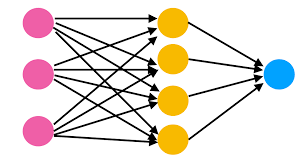

The pink layer is the input ($x$). The yellow layer is the intermediate layer and the blue blob represents the output ($y$). The output can be higher dimensional if required.

The arrows, they represent the hidden layers, more specifically the weights of the layer.

Each hidden layer is basically a weight matrix ($W$) of the shape [output dim, input dim] with an optional bias ($b$) matrix of the shape [output dim]. So, the operation that is performed in a linear layer is basically $-$

$$y = x@W^T +b$$

in terms of shape - $W^T$ has a dimension of [input dim, output dim] and $x$ has a dimension of [input dim]. So, $x@W^T$ has a dimension of [output dim]. The output dim is a hyperparameter that can be chosen.

In this certain figure there are two hidden layers, also termed as linear layer, in Torch. Here, the input dimension is 3, intermediate dimension is 4 and output dimension is 4.

So, the neural network is basically $-$

$$x [3] → \color{red}{Linear(3, 4)} → x_{inter}[4] → \color{red}{Linear(4, 1)} → y[1]$$

Now, if you look closely, this model is still a linear model, just with a bunch of extra weights. So, neural networks do not have inherent non-linearity. Without non-linearity fitting a model on complex problems is actually hard, as we have seen in previous cases. It requires a lot of feature engineering.

But, we are already using a complicated network and the reason we use a complicated network is because we want to overcome complicated feature engineering.

So, how can we add non-linearity?

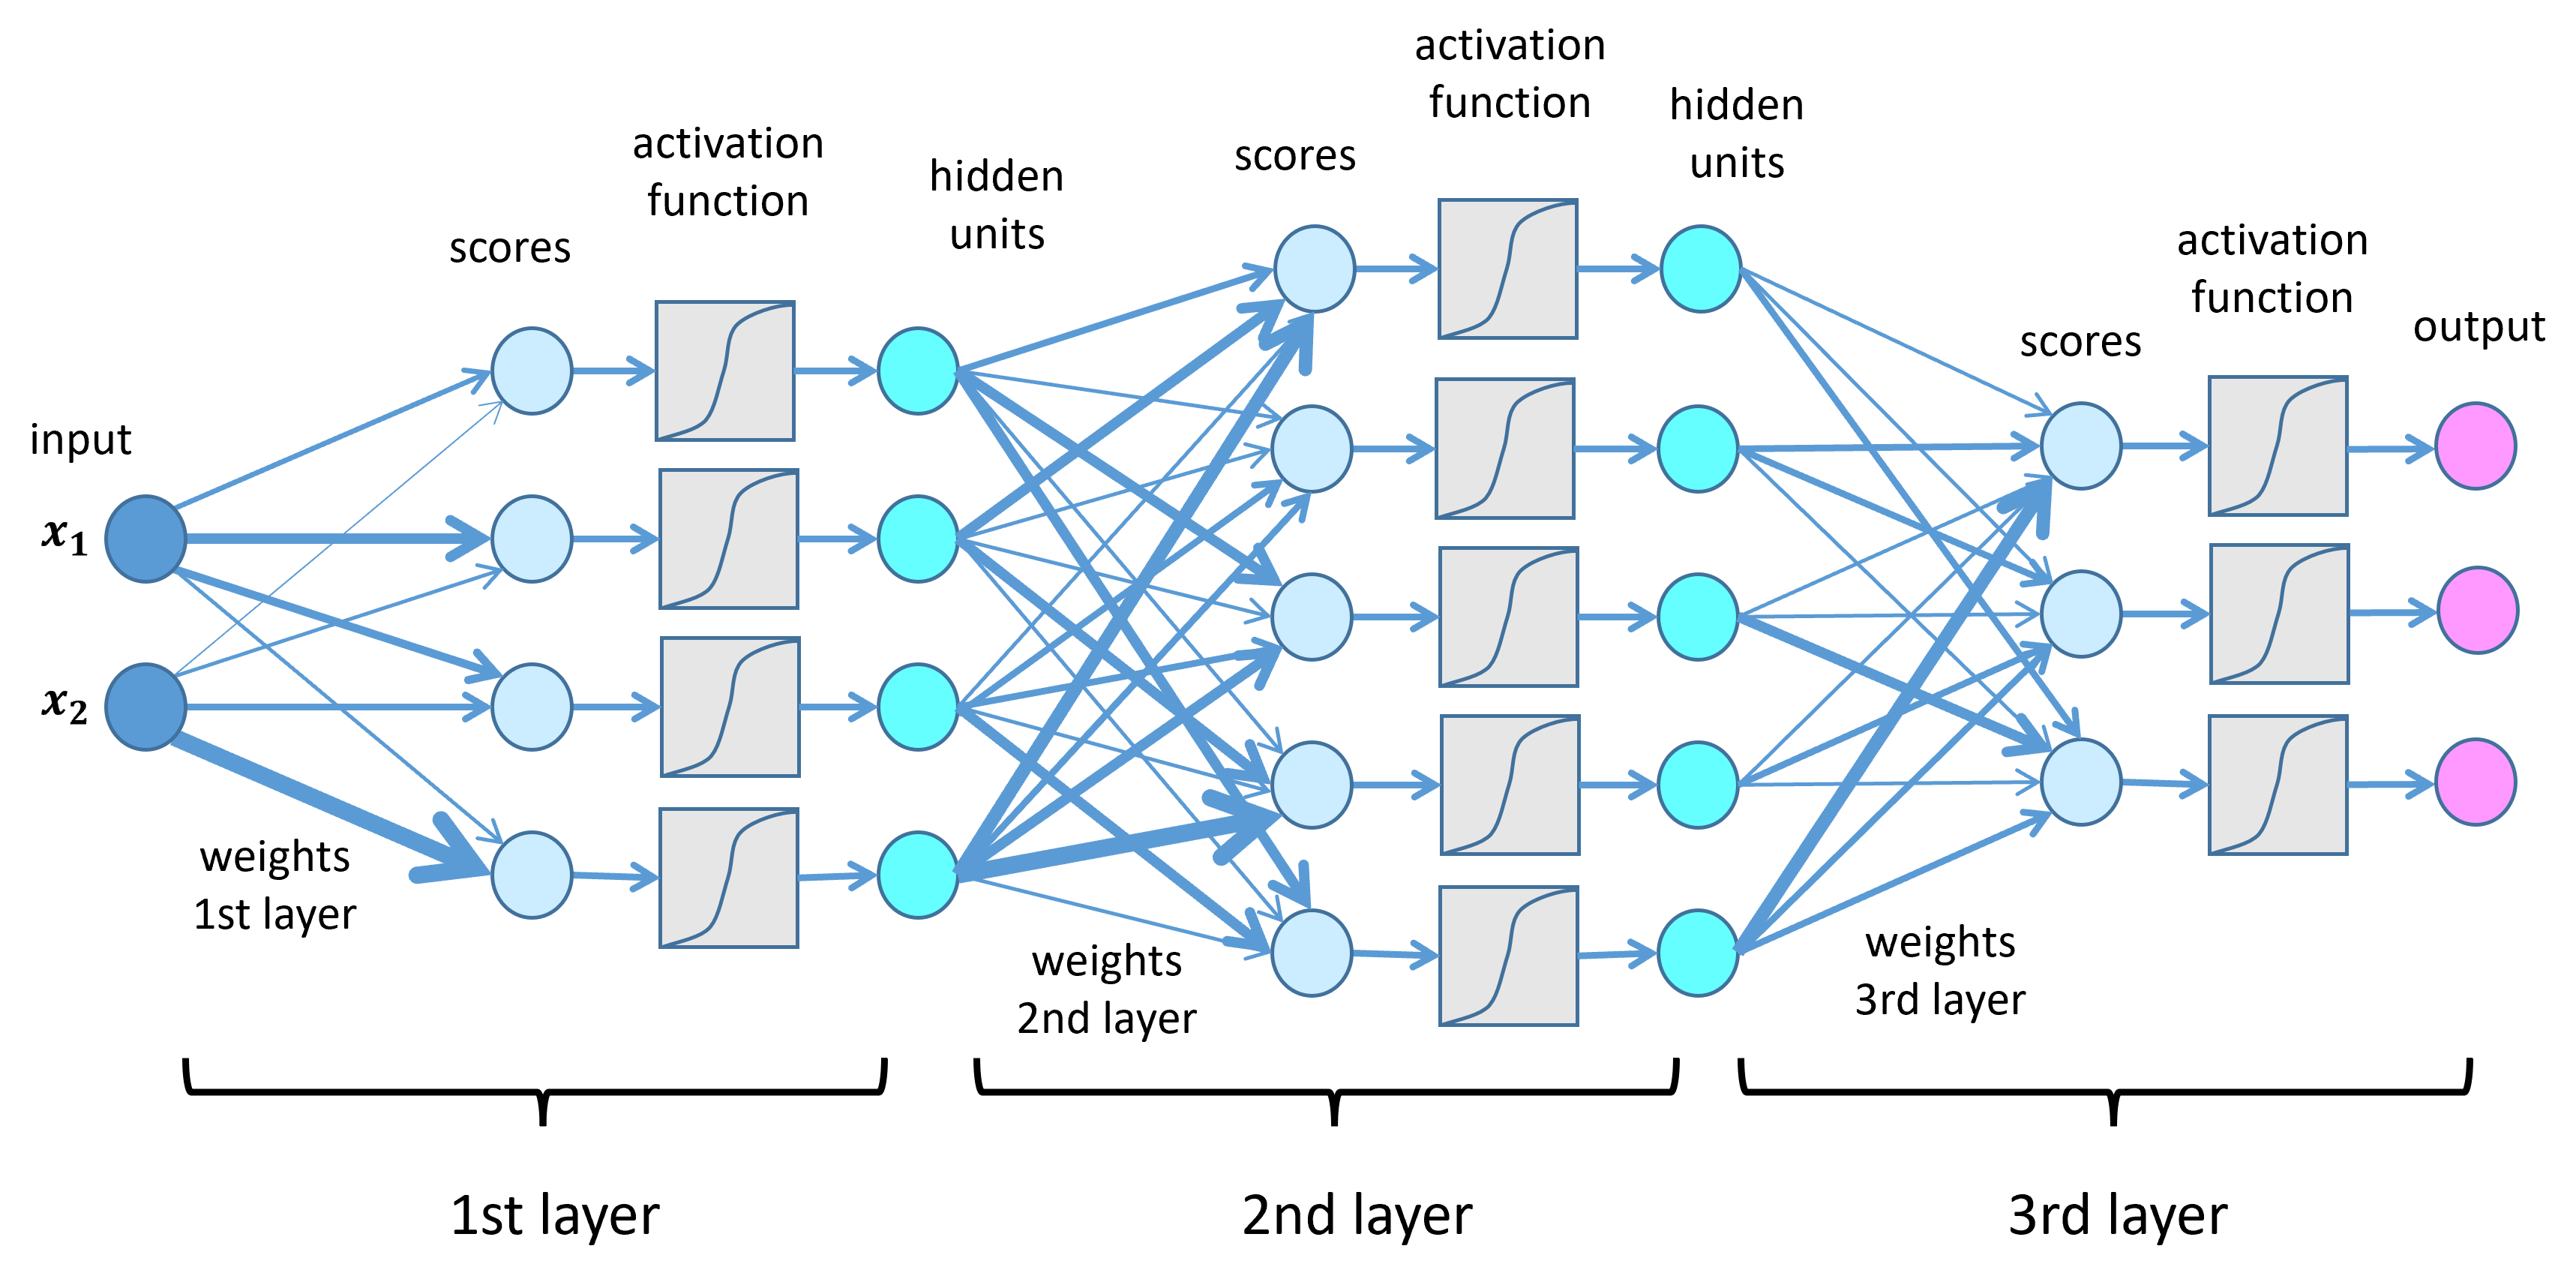

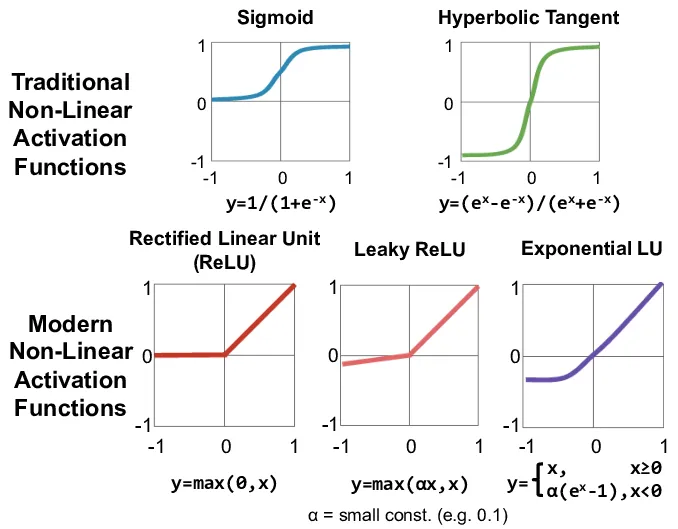

With this information, lets code up a simple neural network.

### Implementing the network skeleton

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim, output_dim):
    # pulls inheritence from nn.Module
    super().__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    self.layer2 = nn.Linear(64, output_dim)

  def forward(self, x):
    # forward function is wrapped with a __call__ wrapper and will be exectuted
    # directly when the class instance is called
    x = self.layer1(x)
    x = F.relu(x)
    x = self.layer2(x)

    #no additional non-linearity is generally added before the output
    return x

For using Torch, you always have to use this syntax. Your model internals can change. You can add other functions and dependencies, but you have to define the layers in \_\_init\_\_ and the connections through function mapping in forward function. The format $-$
```
class YourModelName(nn.Module):
  def __init__(self, other_params):
    super().__init__()
    #your layers go here

  def forward(self, x):
    #your connections go here
    return output
```

After the __init__ declaration, you create a bunch of layers. Conisder a hypothetical space, then your layers would look like -

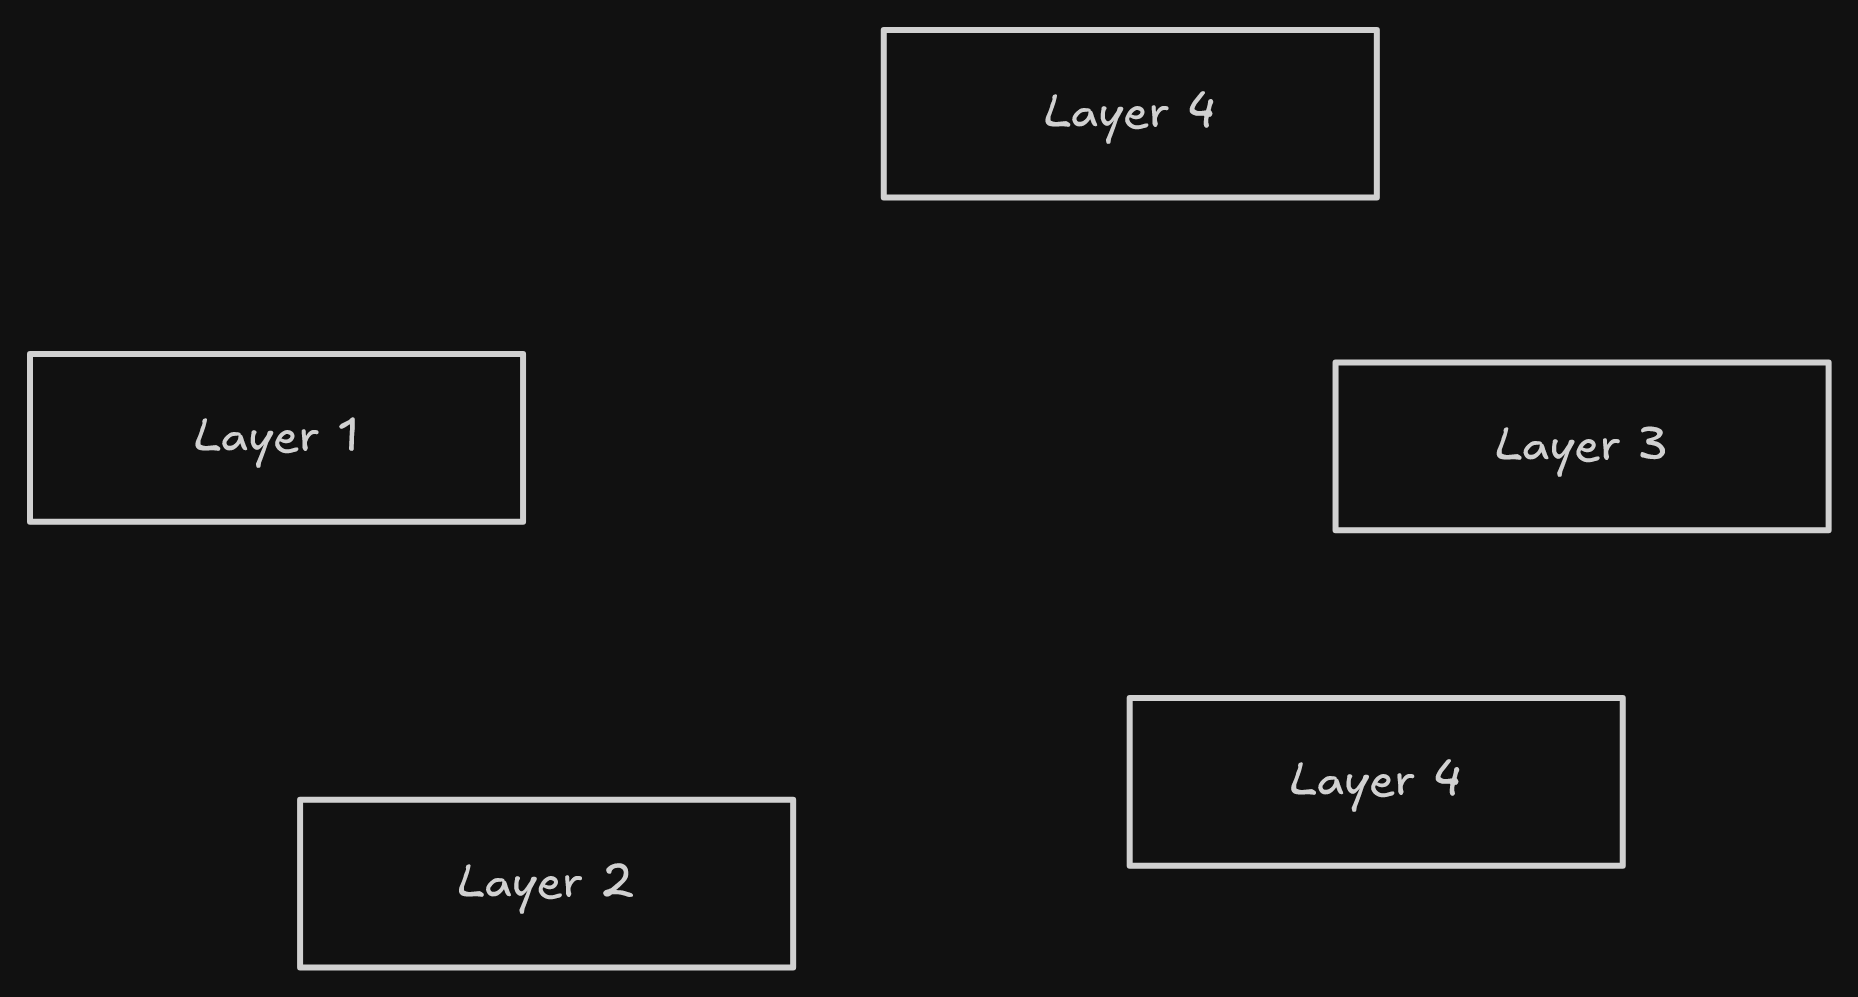

Until you define the forward method, there are no connections. You create connections during the forward method definition -

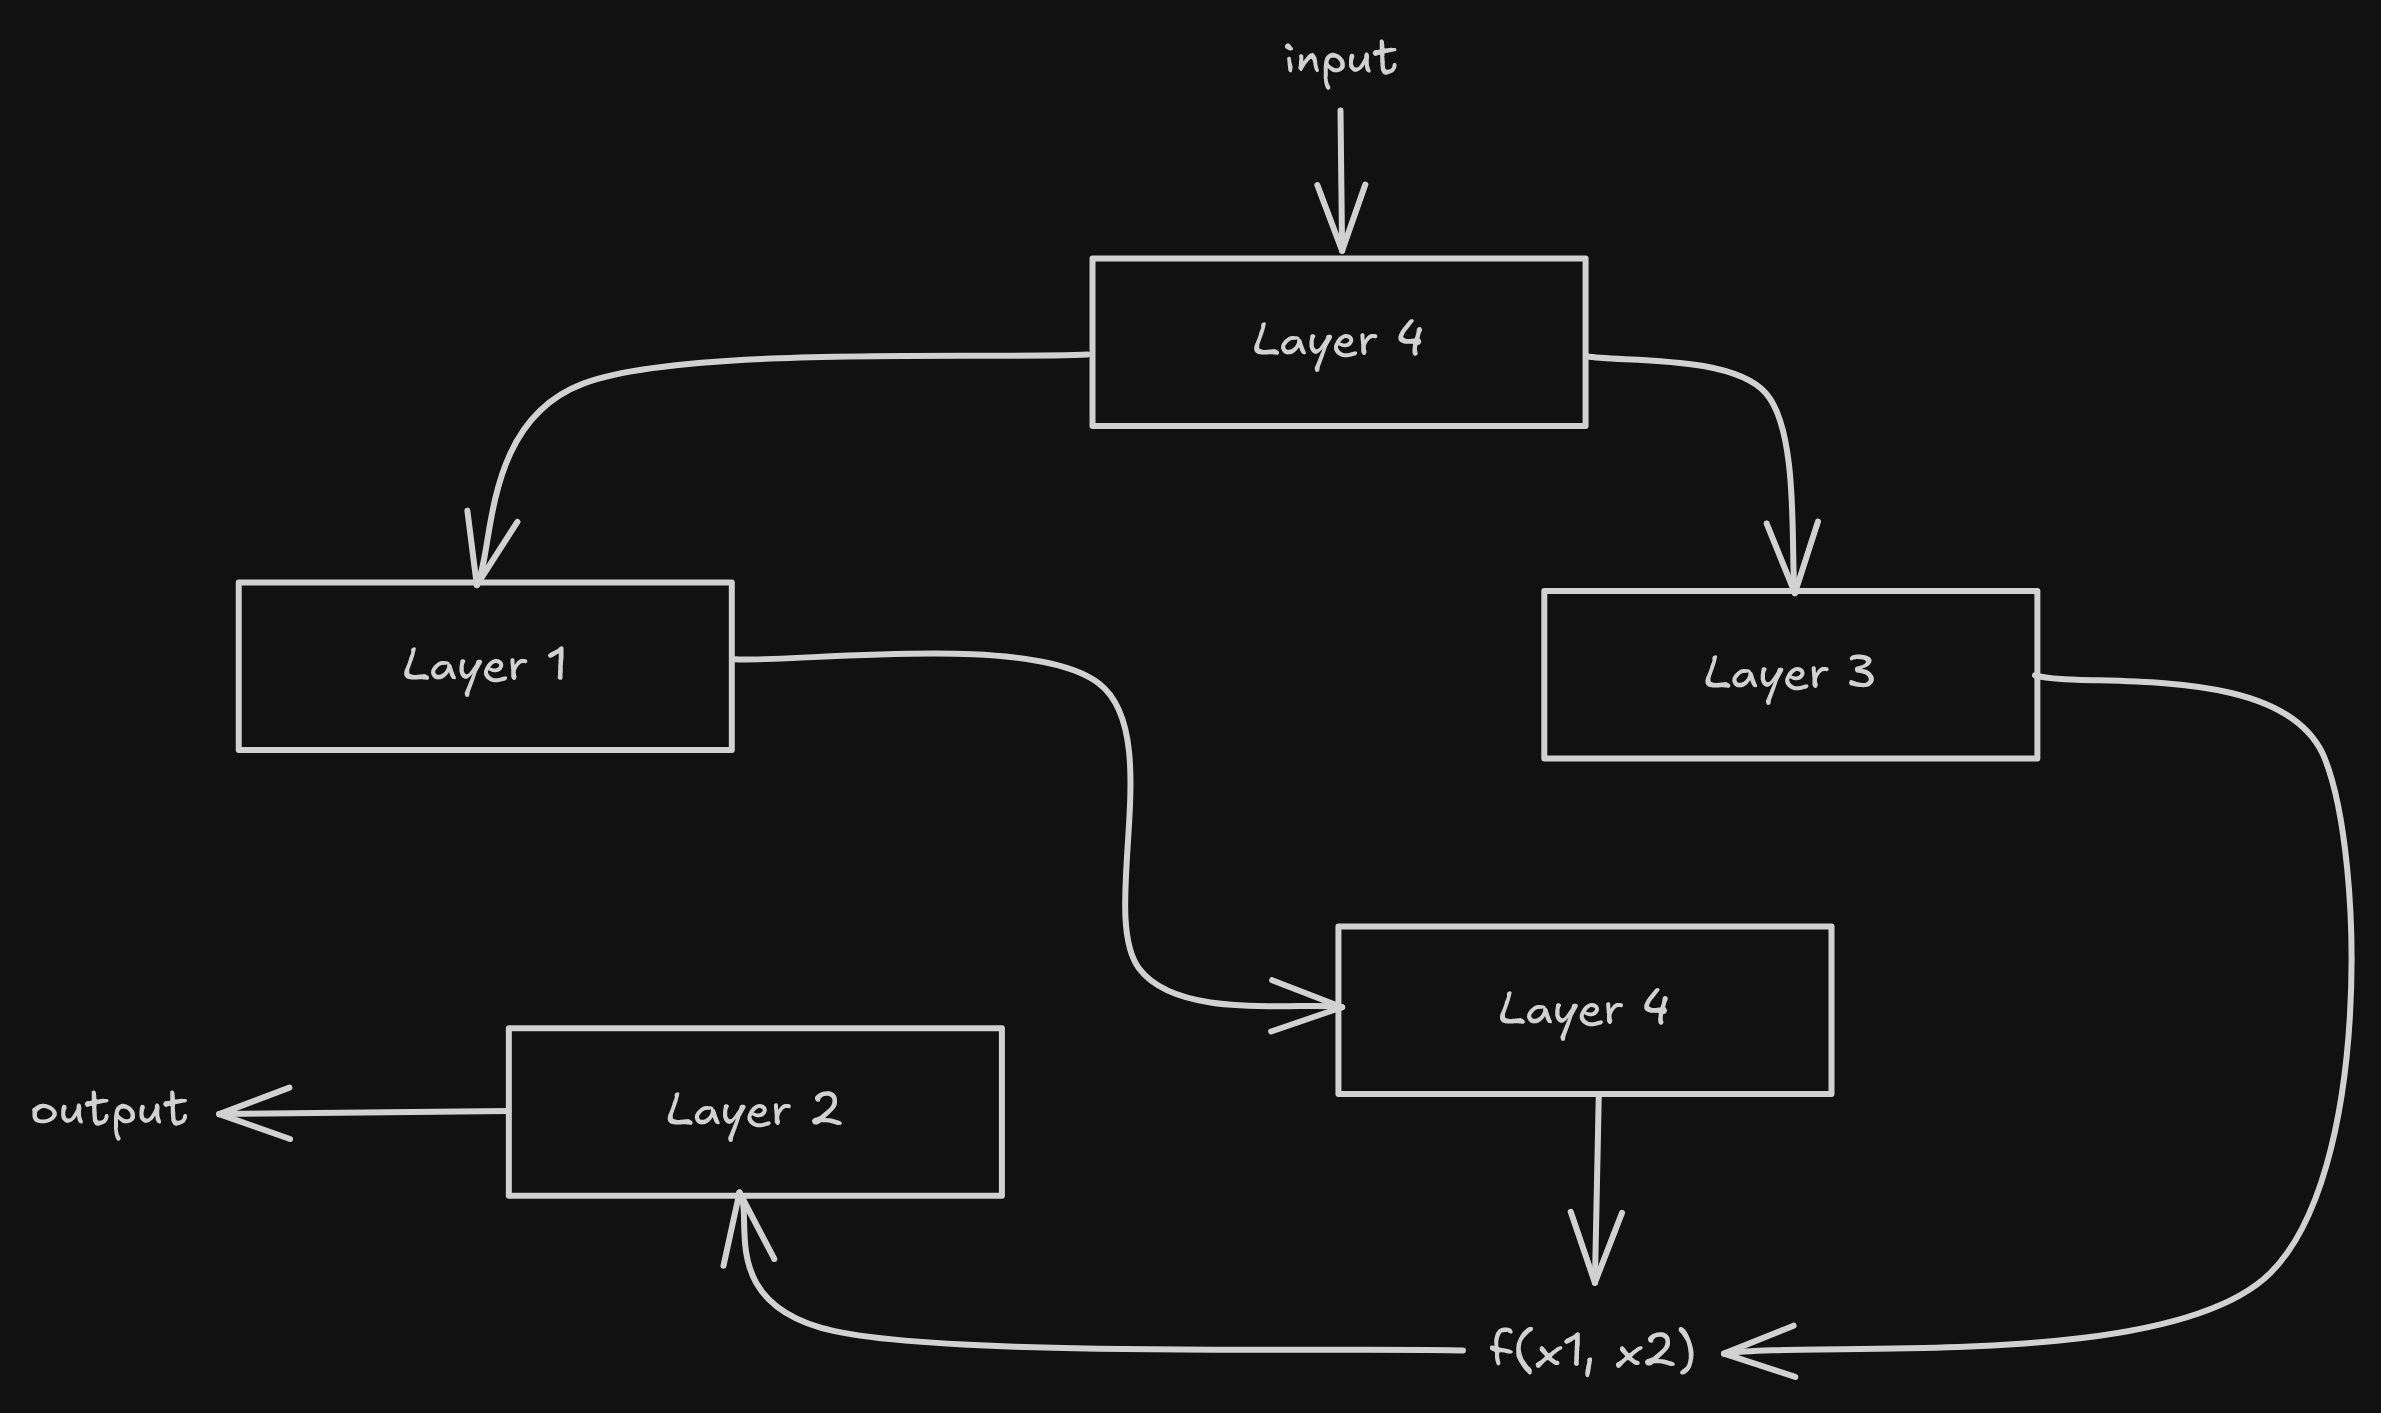

The connection sequence doesn't matter as long as you are maintaining dimensions. Additionally you can add any form of functions on the connection pathways.

Now this class needs to be instantiated before it can be used.

In [ ]:
neural_net = NeuralNet(16, 2)

In [ ]:
neural_net

NeuralNet(
  (layer1): Linear(in_features=16, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
for name, param in neural_net.named_parameters():
    print(f"{name} | shape: {tuple(param.shape)} | requires_grad: {param.requires_grad}")

layer1.weight | shape: (64, 16) | requires_grad: True
layer1.bias | shape: (64,) | requires_grad: True
layer2.weight | shape: (2, 64) | requires_grad: True
layer2.bias | shape: (2,) | requires_grad: True


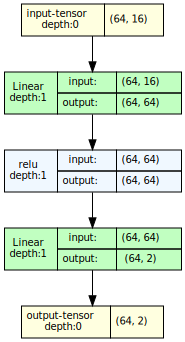

In [ ]:
!pip install torchview -q

from torchview import draw_graph

model_graph = draw_graph(neural_net, input_size=(64, 16), expand_nested=True)
model_graph.visual_graph

Now, notice that I have used an input dimension of [64, 16]. This represents the number of samples, while the 16 represents the feature dimension.

In [ ]:
x_samples = torch.randn(64, 16)
y_samples = neural_net(x_samples)
print(y_samples.shape)

torch.Size([64, 2])


### Adding losses

We have seen how to build a model and how to pass inputs. But how does this model learn?

So passing inputs through the model is called **forward pass**. After forward pass, you get some predictions. Our goal is to bring these predictions close to the original values.

To bring the predicted values close to the original values we need a loss function to understand the goodness of fit. Two go to losses are -

1. MSE loss for regression tasks
2. Cross entropy loss for classification tasks


In [ ]:
y_train_regression = torch.randn(64, 2)
y_train_classification = F.one_hot(torch.randint(2, size = (64,)), 2).double()

#you can instantiate the loss class like this
regression_loss_func = nn.MSELoss()
classification_loss_func = nn.CrossEntropyLoss()

#there is also a direct function to do the same calculation
regression_loss = regression_loss_func(y_samples, y_train_regression).item()
classification_loss = classification_loss_func(y_samples, y_train_classification).item()

print("Regression loss - ", regression_loss)
print("Classification loss - ", classification_loss)

Regression loss -  0.9464805126190186
Classification loss -  0.6886247647926211


### How to deal with gradients?

After calculating the losses, we have to minimize these losses. For neural networks, the most used optimizer is gradient descent or its improved variants like Adagrad, Adam, AdamW etc. The simplest update loop (gradient descent) $-$

$$w_{i} = w_{i} - \alpha*\frac{d}{dw_i} Loss$$

where $\alpha$ is the learning rate.

Now this differentiation is tough now since the function is getting complicated and is quite hard to follow. But Torch expects this. It expects that you may use a gradient based optimizer and so it creates a computational graph keeping track of all the functions applied on the inputs and mapping their gradients so that it can later apply chain rule to find the values.

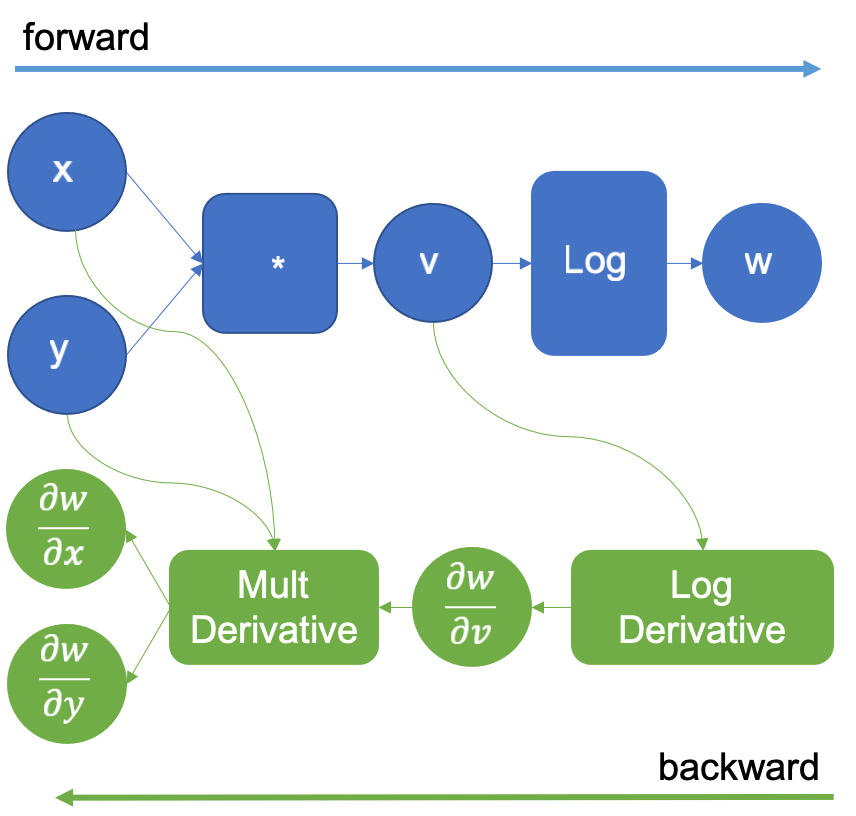

In [ ]:
!pip install torchviz --q

from torchviz import make_dot
from IPython.display import display

neural_net = NeuralNet(16, 2)

output = neural_net(x_samples)

# Visualize the graph of the output or loss
dot = make_dot(output, params=dict(neural_net.named_parameters()))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00


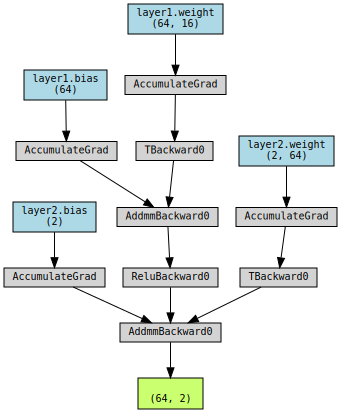

In [ ]:
dot

Although the computation graph is created during the **forward pass**, the gradients are not propagated directly. Instead you have to call the **backward pass** explicitly to push the gradients back. To do this, simply take the loss value and run `loss.backward()` on it to push the loss gradient throughout the network.

We can check the grad across all the model parameters by simply running `parameter.grad`. Lets check the gradients before running `backward()` and after running the function to check our theory.



In [ ]:
neural_net = NeuralNet(16, 2)

x_samples = torch.randn(64, 16)
y_predict = neural_net(x_samples)
y_samples = torch.randn(64, 2)

loss = F.mse_loss(y_samples, y_predict)

print("Before backward pass - \n")
for name, param in neural_net.named_parameters():
  print(f"{name} gradients -\n{param.grad}")

loss.backward()

print("\nAfter backward pass - \n")
for name, param in neural_net.named_parameters():
  print(f"{name} gradients -\n{param.grad}")

Before backward pass - 

layer1.weight gradients -
None
layer1.bias gradients -
None
layer2.weight gradients -
None
layer2.bias gradients -
None

After backward pass - 

layer1.weight gradients -
tensor([[ 0.0056,  0.0168,  0.0105,  ...,  0.0074,  0.0080, -0.0080],
        [-0.0010, -0.0042, -0.0007,  ..., -0.0016, -0.0002,  0.0021],
        [ 0.0183, -0.0291,  0.0009,  ..., -0.0093, -0.0024, -0.0094],
        ...,
        [ 0.0131, -0.0076, -0.0007,  ..., -0.0115,  0.0021, -0.0011],
        [ 0.0054, -0.0209,  0.0074,  ...,  0.0032,  0.0061, -0.0137],
        [ 0.0135,  0.0366, -0.0044,  ...,  0.0100, -0.0070, -0.0040]])
layer1.bias gradients -
tensor([ 7.3157e-04, -2.2403e-03, -2.1077e-03,  5.3197e-05, -6.8292e-04,
         3.7786e-03,  1.3354e-03,  2.0404e-03,  1.1221e-03,  3.1379e-03,
        -3.1065e-03, -1.4759e-03,  1.9741e-03,  3.5469e-03, -9.9175e-03,
         1.3797e-02,  2.0454e-02, -1.4990e-02, -1.2379e-03,  1.3860e-02,
         3.2214e-03, -2.0387e-04, -3.1766e-03, -5.1504

### Adding optimizers to the mix

While `backward()` pushes the gradients through the network, the weight update isn't done yet. The trainable parameters have the gradients. All they need to do now is update themselves using an optimizer. For this you will need an optimizer class instance, and you can simply go do `optimizer.step()`. So, now let us pick an optimizer and see the whole thing in action.

In [ ]:
optimizer = torch.optim.Adam(neural_net.parameters(), lr = 0.01)
optimizer.step()

print("Loss before update - ", loss.item())
print("Loss after update - ", F.mse_loss(y_samples, neural_net(x_samples)).item())

Loss before update -  1.0967568159103394
Loss after update -  0.9867795705795288


### Resetting gradients

Although, Torch handles this pretty nicely, it doesn't clear up the stored gradients after the update. This feature actually adds flexibility for higher level implementations. However, in most general cases we don't need the gradients stored beyond its usage in weight updates. So we have to clear out the gradients manually by running `optimizer.zero_grad()`. You may think, that the gradients are stored inside the parameters, and as such the optimizer instance should not be able to zero them out. You have to remember that we gave access of the network parameters to the optimizers while instantiating, hence the optimizer can indeed zero out the gradients. You can manually do it too, but this is a more elegant way of getting the job done.

In [ ]:
print("Before zeroing out gradients - \n")
for name, param in neural_net.named_parameters():
  print(f"{name} gradients -\n{param.grad}")

optimizer.zero_grad()

print("\nAfter zeroing out gradients - \n")
for name, param in neural_net.named_parameters():
  print(f"{name} gradients -\n{param.grad}")

Before zeroing out gradients - 

layer1.weight gradients -
tensor([[ 0.0056,  0.0168,  0.0105,  ...,  0.0074,  0.0080, -0.0080],
        [-0.0010, -0.0042, -0.0007,  ..., -0.0016, -0.0002,  0.0021],
        [ 0.0183, -0.0291,  0.0009,  ..., -0.0093, -0.0024, -0.0094],
        ...,
        [ 0.0131, -0.0076, -0.0007,  ..., -0.0115,  0.0021, -0.0011],
        [ 0.0054, -0.0209,  0.0074,  ...,  0.0032,  0.0061, -0.0137],
        [ 0.0135,  0.0366, -0.0044,  ...,  0.0100, -0.0070, -0.0040]])
layer1.bias gradients -
tensor([ 7.3157e-04, -2.2403e-03, -2.1077e-03,  5.3197e-05, -6.8292e-04,
         3.7786e-03,  1.3354e-03,  2.0404e-03,  1.1221e-03,  3.1379e-03,
        -3.1065e-03, -1.4759e-03,  1.9741e-03,  3.5469e-03, -9.9175e-03,
         1.3797e-02,  2.0454e-02, -1.4990e-02, -1.2379e-03,  1.3860e-02,
         3.2214e-03, -2.0387e-04, -3.1766e-03, -5.1504e-04, -1.3720e-03,
        -2.6462e-03, -1.7622e-03, -8.6720e-03,  6.7184e-03,  4.5706e-03,
        -2.5155e-03, -9.9220e-03, -2.3482e-03

### Bringing it all together

Now we know how to update the weights through a combination of forward and backward passes. But we did it once. In gradient based solvers, you have to update the weights for a few iterations, termed as epoch in the ML lingo. So, we do whatever we did till now but we wrap everything in a loop.

In [ ]:
neural_net = NeuralNet(16, 2)

x_samples = torch.randn(64, 16)
y_samples = torch.randn(64, 2)

optimizer = torch.optim.Adam(neural_net.parameters(), lr = 0.01)

epochs = 10
for epoch in range(epochs):
  y_predict = neural_net(x_samples)
  loss = F.mse_loss(y_predict, y_samples)

  # just to be safe, we generally use optimizer.zero_grad() at the start
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print(f"Epoch {epoch + 1} loss - ", loss.item())

Epoch 1 loss -  0.913389265537262
Epoch 2 loss -  0.8256012201309204
Epoch 3 loss -  0.7633355855941772
Epoch 4 loss -  0.7076712846755981
Epoch 5 loss -  0.6579440236091614
Epoch 6 loss -  0.6132108569145203
Epoch 7 loss -  0.5727601051330566
Epoch 8 loss -  0.5340739488601685
Epoch 9 loss -  0.49574872851371765
Epoch 10 loss -  0.45932096242904663


### Summarizing

The overall pipeline becomes $-$

```
1. Define the model structure as a class
2. Instantiate a model object
3. Do for n epochs -
  i. Forward pass to get predictions
  ii. Calculate loss
  iii. Zero the gradient values
  iv. Backward pass the loss
  v. Update the weights using optimizer.step()

```



# Application on a real dataset

## California housing dataset (regression)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = sklearn.datasets.fetch_california_housing()

In [ ]:
x = dataset.data
y = dataset.target

x = (x - x.mean(axis = 0, keepdims = True))/x.std(axis = 0, keepdims = True)

x, y = x.astype(np.float32), y.astype(np.float32)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2, random_state=333) 

Lets try Scikit-learn's linear regression at first and see how it goes.

In [ ]:
model = sklearn.linear_model.LinearRegression()
model = model.fit(x_train, y_train)
y_predict = model.predict(x_test)

mse_train = np.mean((y_train - model.predict(x_train))**2)
print("Training loss:", mse_train)
mse_test = np.mean((y_test - y_predict)**2)
print("Testing loss:", mse_test)

Training loss: 0.5283772
Testing loss: 0.5098554


Scikit-learn works with NumPy arrays, whereas Torch works with Torch tensors and cannot operate with NumPy arrays. As such, you have to convert the NumPy arrays to Torch tensor before you can pass them through Torch models.

In [ ]:
x_train, y_train = torch.tensor(x_train, device = device), torch.tensor(y_train, device = device)
x_test, y_test = torch.tensor(x_test, device = device), torch.tensor(y_test, device = device)

In [ ]:
print(f"Number of train samples - {x_train.shape[0]}")
print(f"Number of test samples - {x_test.shape[0]}")
print(f"Feature numbers - {x_train.shape[1]}")

Number of train samples - 16512
Number of test samples - 4128
Feature numbers - 8


In [ ]:
class Regressor(nn.Module):
  def __init__(self, input_dim = 8, output_dim = 1):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, 16)
    self.layer2 = nn.Linear(16, 32)
    self.layer3 = nn.Linear(32, output_dim)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)

    return x

In [ ]:
regressor = Regressor().to(device)
optimizer = torch.optim.Adam(regressor.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
  y_predict = regressor(x_train).squeeze()
  loss = loss_fn(y_predict, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1)%100 == 0:
    print(f"Epoch {epoch + 1} | Loss - {loss}")

regressor.eval()
y_predict = regressor(x_test).squeeze()
print("\nTest loss - ", F.mse_loss(y_predict, y_test).item())

Epoch 100 | Loss - 0.3774782419204712
Epoch 200 | Loss - 0.347221314907074
Epoch 300 | Loss - 0.3263358771800995
Epoch 400 | Loss - 0.30882972478866577
Epoch 500 | Loss - 0.29436132311820984
Epoch 600 | Loss - 0.28186357021331787
Epoch 700 | Loss - 0.2713637351989746
Epoch 800 | Loss - 0.26501578092575073
Epoch 900 | Loss - 0.2602781355381012
Epoch 1000 | Loss - 0.25653016567230225

Test loss -  0.2850102186203003


Clearly, the neural network hugely outperformed the Scikit-learn's linear regressor. But please note that blindly choosing neural network is never the solution and neural networks may not give you the edge every time.